Importación de las bibliotecas

## 📊 Estructura del Notebook

Este notebook implementa un **Sistema de Recomendación basado en Redes Bipartitas** utilizando el dataset de Amazon Electronics Reviews.

### Secciones principales:

1. **Construcción del Grafo Bipartito**
   - Carga de datos con rutas relativas
   - Filtrado de reseñas de 5 estrellas
   - Creación del grafo bipartito (usuarios ↔ productos)
   - Visualización de la matriz de biadyacencia

2. **Análisis de la Red Bipartita**
   - Cálculo de grados de conectividad
   - Identificación de usuarios y productos más activos
   - Visualización de distribuciones

3. **Proyección a Red de Productos**
   - Proyección ponderada sobre productos
   - Análisis de pesos (usuarios compartidos)

4. **Sistema de Recomendación**
   - Algoritmo: **Similaridad de Jaccard**
   - Métricas de evaluación
   - Filtrado de productos duplicados

5. **Visualización e Interactividad**
   - Red estrella (star network) con producto central
   - Interfaz interactiva con dropdowns (ipywidgets)
   - Selección dinámica de productos y número de recomendaciones

---

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

# Sistema de recomendación usando una proyección de red bipartita

**Integrantes:** Isaac Cerda, David Guamán, Christian Jácome, Mateo Jaramillo, David Navarrete

## Preparación de Datos

### **Paso 1:** Descargar el Dataset
Ejecutar **SOLO** si **NO** se tiene la carpeta `data` en el directorio `src/app` con el archivo `ratings_electronics.csv`

In [2]:
from utils.download_dataset import download_ratings_electronics

dataset_path = download_ratings_electronics()

ModuleNotFoundError: No module named 'kagglehub'

### **Paso 2:** Cargar el Dataset

In [42]:
import pandas as pd
import os

# Ruta relativa al dataset desde la ubicación del notebook
dataset_path = os.path.join(os.path.dirname(os.path.abspath('__file__')), 
                            'data', 'amazon-products-reviews', 'ratings_electronics.csv')

# Carga del dataset
electronics_data = pd.read_csv(
    dataset_path, names=['userId', 'productId', 'Rating', 'timestamp']
)

# Impresión de las primeras 5 filas
electronics_data.head()

,userId,productId,Rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


#### **Paso 2.1:** Revisar cantidad de datos del Dataset

In [3]:
electronics_data.info()
electronics_data.describe()
print(f"Total registros: {len(electronics_data):,}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     object 
 1   productId  object 
 2   Rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB
Total registros: 7,824,482
Total registros: 7,824,482


### **Paso 3:** Filtrar reseñas de 5 estrellas

In [4]:
electronics_data = electronics_data[electronics_data['Rating'] == 5]
print(f"Registros luego de filtrar 5 estrellas: {len(electronics_data):,}")

Registros luego de filtrar 5 estrellas: 4,347,541


### **Paso 4:** Eliminar usuarios y productos con pocas conexiones

In [5]:
# Contar cuántos ratings tiene cada usuario y producto
user_counts = electronics_data['userId'].value_counts()
product_counts = electronics_data['productId'].value_counts()

# Mantener usuarios y productos con al menos 4 interacciones
min_user_reviews = 4
min_product_reviews = 4

filtered_users = user_counts[user_counts >= min_user_reviews].index
filtered_products = product_counts[product_counts >= min_product_reviews].index

electronics_data = electronics_data[
    electronics_data['userId'].isin(filtered_users) &
    electronics_data['productId'].isin(filtered_products)
]

print(f"Registros tras filtrado de conexiones mínimas: {len(electronics_data):,}")


Registros tras filtrado de conexiones mínimas: 1,147,489


#### **Paso 4.1:** Validar campos nulos tras el filtrado

In [6]:
electronics_data.isnull().sum()

userId       0
productId    0
Rating       0
timestamp    0
dtype: int64

## Construcción de la Red Bipartita

---

## **Sección 1: Construcción del Grafo Bipartito**

El grafo bipartito conecta dos conjuntos disjuntos de nodos:
- **Conjunto U**: Usuarios que califican productos
- **Conjunto V**: Productos que reciben calificaciones

Las aristas representan interacciones (calificaciones de 5 estrellas) entre usuarios y productos.

### **Paso 1:** Reducir cantidad de Nodos

Debido a que el dataset es muy grande, se toma una muestra

In [7]:
import random

users = electronics_data['userId'].unique()
products = electronics_data['productId'].unique()

print("Antes de la muestra:")
print(f"Número de usuarios únicos: {len(users)}")
print(f"Número de productos únicos: {len(products)}")

users = list(users)
products = list(products)

sample_ratio = 0.1

num_users = int(len(users) * sample_ratio)
num_products = int(len(products) * sample_ratio)

random.seed(42)
users = random.sample(users, num_users)
products = random.sample(products, num_products)

print("Después de la muestra:")
print(f"Número de usuarios únicos: {len(users)}")
print(f"Número de productos únicos: {len(products)}")

Antes de la muestra:
Número de usuarios únicos: 184707
Número de productos únicos: 107686
Después de la muestra:
Número de usuarios únicos: 18470
Número de productos únicos: 10768


### **Paso 2:** Crear red bipartita

In [8]:
import networkx as nx

B = nx.Graph()

# Agregar nodos al grafo
B.add_nodes_from(users, bipartite=0)
B.add_nodes_from(products, bipartite=1)

# Agregar aristas
edges = electronics_data[['userId', 'productId']].values
B.add_edges_from(edges)

is_bipartite = nx.is_bipartite(B)
print(f"¿Es el grafo bipartito? {"Sí" if is_bipartite else "No"}")
num_edges = B.number_of_edges()
print("Número de aristas:", num_edges)

¿Es el grafo bipartito? Sí
Número de aristas: 1147489


### **Paso 3:** Generar matriz de biadyacencia

Se utiliza la matriz de biadyacencia dispersa, que es una forma eficiente de representar grandes grafos bipartitos en memoria.

- Cada **fila** representa un usuario
- Cada **columna** representa un producto  
- Los valores **distintos de cero** indican una conexión (interacción usuario-producto)

La razón principal para trabajar con una matriz dispersa (sparse) en lugar de una matriz completa es que la mayoría de las celdas son ceros, permitiendo ahorrar memoria y procesar grafos grandes de forma eficiente.

In [9]:
from networkx.algorithms import bipartite
import pandas as pd

# Obtener matriz de biadyacencia en formato disperso (sparse)
matrix_sparse = bipartite.biadjacency_matrix(B, row_order=users, column_order=products)

# Mostrar información general de la matriz
print("Matriz de biadyacencia (formato disperso):")
print(matrix_sparse)
print(f"Tamaño: {matrix_sparse.shape}")
print(f"Número de conexiones (valores distintos de 0): {matrix_sparse.nnz}")

# Extraer los índices (posiciones) de los valores distintos de cero
row_idx, col_idx = matrix_sparse.nonzero()

# Crear un DataFrame con los enlaces reales (usuario - producto)
edges_nonzero = pd.DataFrame({
    'userId': [users[i] for i in row_idx],
    'productId': [products[j] for j in col_idx]
})

print("\nConexiones reales (valores distintos de 0):")
print(edges_nonzero.head(10))  # Muestra solo los primeros 10 para no saturar la salida

Matriz de biadyacencia (formato disperso):
<Compressed Sparse Row sparse array of dtype 'int64'
	with 11532 stored elements and shape (18470, 10768)>
  Coords	Values
  (2, 5156)	1
  (5, 5693)	1
  (5, 10206)	1
  (7, 11)	1
  (9, 1123)	1
  (10, 575)	1
  (10, 1837)	1
  (10, 3982)	1
  (10, 6990)	1
  (12, 7294)	1
  (14, 6874)	1
  (15, 9333)	1
  (16, 8018)	1
  (17, 1170)	1
  (20, 510)	1
  (20, 2456)	1
  (25, 9357)	1
  (28, 969)	1
  (32, 5573)	1
  (33, 1508)	1
  (34, 1949)	1
  (34, 2074)	1
  (41, 3838)	1
  (42, 1328)	1
  (44, 3414)	1
  :	:
  (18443, 7159)	1
  (18445, 9996)	1
  (18448, 3799)	1
  (18448, 10741)	1
  (18450, 276)	1
  (18450, 1543)	1
  (18450, 1802)	1
  (18450, 2037)	1
  (18450, 4422)	1
  (18450, 6596)	1
  (18450, 8436)	1
  (18450, 9591)	1
  (18450, 10404)	1
  (18452, 9644)	1
  (18457, 5665)	1
  (18459, 1543)	1
  (18459, 3397)	1
  (18459, 5650)	1
  (18459, 7432)	1
  (18459, 10737)	1
  (18460, 9124)	1
  (18461, 9643)	1
  (18466, 6169)	1
  (18467, 10730)	1
  (18469, 2694)	1
Tamaño: (

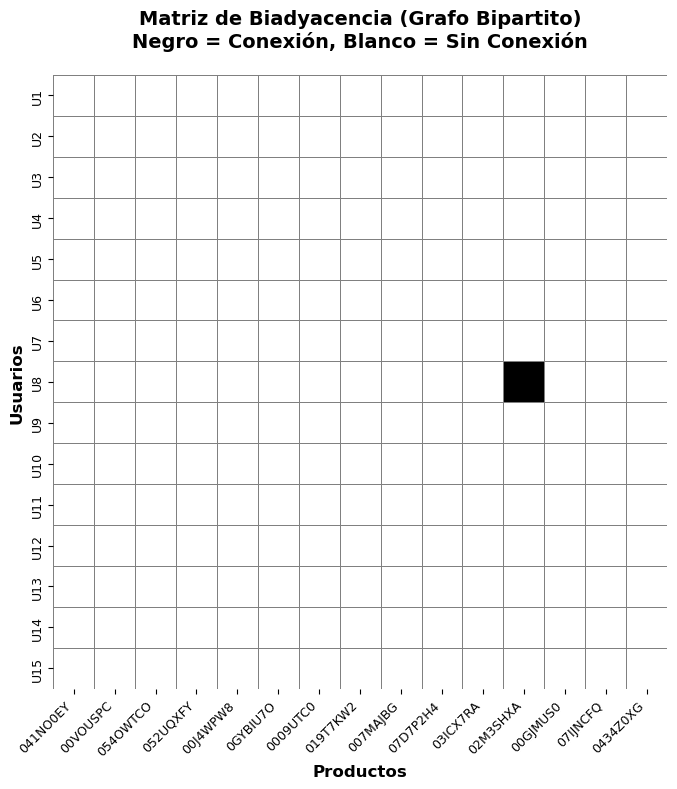


Visualizando 15 usuarios × 15 productos
Conexiones en esta muestra: 1


In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualización de la matriz de biadyacencia (muestra pequeña)
fig, ax = plt.subplots(figsize=(12, 8))

# Tomar una muestra pequeña para visualización
sample_users = users[:15] if len(users) >= 15 else users
sample_products = products[:15] if len(products) >= 15 else products

# Obtener submatriz para la muestra
user_indices = [users.index(u) for u in sample_users]
product_indices = [products.index(p) for p in sample_products]
sample_matrix = matrix_sparse[user_indices, :][:, product_indices].toarray()

# Crear heatmap
sns.heatmap(sample_matrix, 
            cmap='binary',
            cbar=False,
            xticklabels=[p[-8:] for p in sample_products],
            yticklabels=[f'U{i+1}' for i in range(len(sample_users))],
            square=True,
            linewidths=0.5,
            linecolor='gray',
            ax=ax)

ax.set_xlabel('Productos', fontsize=12, fontweight='bold')
ax.set_ylabel('Usuarios', fontsize=12, fontweight='bold')
ax.set_title('Matriz de Biadyacencia (Grafo Bipartito)\nNegro = Conexión, Blanco = Sin Conexión', 
             fontsize=14, fontweight='bold', pad=20)

plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.show()

print(f"\nVisualizando {len(sample_users)} usuarios × {len(sample_products)} productos")
print(f"Conexiones en esta muestra: {sample_matrix.sum():.0f}")

---

## **Sección 2: Análisis de la Red Bipartita**

### **Paso 4:** Graficar nodos con mayores conexiones

Se calculan los grados de los nodos (número de conexiones):

- `num_products_rated`: cuántos productos calificó cada usuario.
- `num_ratings_received`: cuántos usuarios calificaron cada producto.

Luego se seleccionan los Top N nodos más conectados en cada grupo `nlargest`.


Grados de los primeros usuarios:
           userId  num_products_rated
0  A3RNVG2VPZGC6Z                   4
1  A2MLPFHL4YOZX0                   7
2  A22M9RH5461NC9                   9
3  A2B09MGT1H44LY                   5
4  A24L9693W832UC                   4

Grados de los primeros productos:
    productId  num_ratings_received
0  B0041NO0EY                     1
1  B000VOUSPC                     1
2  B0054OWTCO                     2
3  B0052UQXFY                     8
4  B000J4WPW8                    56


C:\Users\isaac\AppData\Local\Temp\ipykernel_16616\2185075639.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_users, x="num_products_rated", y="userId", palette="Blues_d")
C:\Users\isaac\AppData\Local\Temp\ipykernel_16616\2185075639.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_products, x="num_ratings_received", y="productId", palette="Greens_d")


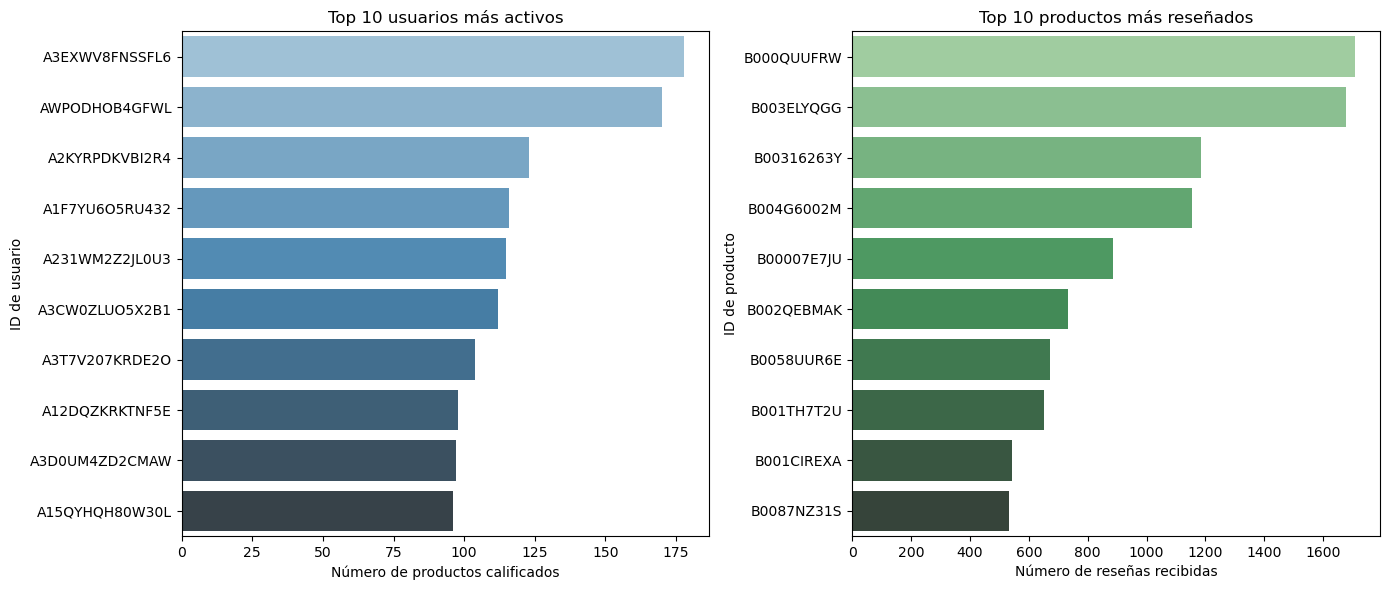

In [10]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite
import seaborn as sns

# Calcular grados de los usuarios y productos
user_degrees = dict(B.degree(users))
product_degrees = dict(B.degree(products))

user_deg_df = pd.DataFrame(user_degrees.items(), columns=["userId", "num_products_rated"])
product_deg_df = pd.DataFrame(product_degrees.items(), columns=["productId", "num_ratings_received"])

print("\nGrados de los primeros usuarios:")
print(user_deg_df.head())

print("\nGrados de los primeros productos:")
print(product_deg_df.head())

# --- Top N nodos ---
N = 10
top_users = user_deg_df.nlargest(N, "num_products_rated")
top_products = product_deg_df.nlargest(N, "num_ratings_received")

plt.figure(figsize=(14, 6))

# Top N usuarios más activos
plt.subplot(1, 2, 1)
sns.barplot(data=top_users, x="num_products_rated", y="userId", palette="Blues_d")
plt.title(f"Top {N} usuarios más activos")
plt.xlabel("Número de productos calificados")
plt.ylabel("ID de usuario")

# Top N productos más reseñados
plt.subplot(1, 2, 2)
sns.barplot(data=top_products, x="num_ratings_received", y="productId", palette="Greens_d")
plt.title(f"Top {N} productos más reseñados")
plt.xlabel("Número de reseñas recibidas")
plt.ylabel("ID de producto")

plt.tight_layout()
plt.show()


#### **Paso 4.1:** Mostrar resultado final

In [11]:
import numpy as np

# Calcular grados de los usuarios y productos
user_degrees = dict(B.degree(users))
product_degrees = dict(B.degree(products))

print(f"Número de usuarios: {len(users)}")
print(f"Número de productos: {len(products)}")
print(f"Número de aristas (reseñas de 5 estrellas): {B.number_of_edges()}")
print(f"Grado promedio de usuarios: {np.mean(list(user_degrees.values())):.2f}")
print(f"Grado promedio de productos: {np.mean(list(product_degrees.values())):.2f}")

Número de usuarios: 18470
Número de productos: 10768
Número de aristas (reseñas de 5 estrellas): 1147489
Grado promedio de usuarios: 6.19
Grado promedio de productos: 10.82


---

## **Sección 3: Proyección a Red de Productos**

La proyección conecta productos que comparten usuarios en común.

**Proceso:**
1. Se toma el grafo bipartito B(U, V, E)
2. Se proyecta sobre el conjunto V (productos)
3. Dos productos quedan conectados si tienen al menos un usuario en común
4. El **peso de la arista** = número de usuarios compartidos

**Ejemplo:** Si los productos P1 y P2 fueron calificados por 15 usuarios en común, la arista (P1, P2) tendrá peso = 15.

In [12]:
# Crear la proyección de productos
# Esto conecta productos que fueron calificados por los mismos usuarios
product_network = bipartite.weighted_projected_graph(B, products)

print(f"Red de productos creada:")
print(f"Número de productos: {product_network.number_of_nodes()}")
print(f"Número de conexiones entre productos: {product_network.number_of_edges()}")

# Verificar algunos pesos de las conexiones
if product_network.number_of_edges() > 0:
    # Obtener algunas aristas con sus pesos
    sample_edges = list(product_network.edges(data=True))[:5]
    print("\nEjemplos de conexiones entre productos (peso = usuarios en común):")
    for edge in sample_edges:
        prod1, prod2, data = edge
        weight = data['weight']
        print(f"  {prod1} -- {prod2}: {weight} usuarios en común")

Red de productos creada:
Número de productos: 89346
Número de conexiones entre productos: 1039629

Ejemplos de conexiones entre productos (peso = usuarios en común):
  B0041NO0EY -- B0047FW7LE: 1 usuarios en común
  B0041NO0EY -- B0041NRY6A: 1 usuarios en común
  B0041NO0EY -- B0041NQ00Q: 1 usuarios en común
  B0041NO0EY -- B001FA1O0O: 1 usuarios en común
  B000VOUSPC -- B003Z6AB0A: 1 usuarios en común


---

## **Sección 4: Sistema de Recomendación con Similaridad de Jaccard**

### **Algoritmo implementado**

**Similaridad de Jaccard** mide qué tan similares son dos productos basándose en sus usuarios compartidos:

$$J(A, B) = \frac{|A \cap B|}{|A \cup B|} \times 100\%$$

Donde:
- $A$: conjunto de usuarios que calificaron el producto A
- $B$: conjunto de usuarios que calificaron el producto B  
- $|A \cap B|$: usuarios que calificaron ambos productos
- $|A \cup B|$: usuarios que calificaron al menos uno de los dos productos

**Características:**
- Rango: 0% (sin usuarios en común) a 100% (mismos usuarios exactamente)
- Es **simétrica**: $J(A,B) = J(B,A)$
- Normaliza por el tamaño total de la unión (evita sesgo por popularidad)

**Caso especial:** 100% de similaridad indica que dos productos tienen exactamente el mismo conjunto de usuarios, lo que puede indicar:
- Productos duplicados en el catálogo
- Variantes del mismo producto (diferentes colores/tamaños)
- El algoritmo puede filtrar estos casos si se desea

In [38]:
def get_product_recommendations(product_id, n_recommendations=5, exclude_perfect_match=True):
    """
    Obtiene recomendaciones basadas en SIMILITUD DE JACCARD
    
    SIMILITUD DE JACCARD:
    - Métrica estándar para sistemas de recomendación
    - Fórmula: J(A,B) = |A ∩ B| / |A ∪ B|
    - Rango: 0% a 100%
    
    NOTA: 100% significa que exactamente los mismos usuarios calificaron ambos productos
    (A = B), lo cual puede indicar productos duplicados o variantes del mismo producto.
    
    Args:
        product_id: ID del producto
        n_recommendations: Número de recomendaciones
        exclude_perfect_match: Si True, excluye productos con 100% de similaridad
    
    Returns: Lista de tuplas (producto_id, porcentaje_jaccard, info_adicional)
    """
    if product_id not in product_network:
        return []
    
    neighbors = product_network[product_id].items()
    users_base = set(B.neighbors(product_id))
    num_users_base = len(users_base)
    
    recommendations = []
    for neighbor, data in neighbors:
        users_common = data['weight']
        users_neighbor = set(B.neighbors(neighbor))
        num_users_neighbor = len(users_neighbor)
        
        # SIMILITUD DE JACCARD: |A ∩ B| / |A ∪ B|
        union_size = num_users_base + num_users_neighbor - users_common
        jaccard_similarity = (users_common / union_size) * 100 if union_size > 0 else 0
        
        # Información adicional para análisis
        info = {
            'users_base': num_users_base,
            'users_neighbor': num_users_neighbor,
            'users_common': users_common,
            'is_perfect_match': (jaccard_similarity == 100.0)
        }
        
        # Filtrar coincidencias perfectas si se solicita
        if exclude_perfect_match and jaccard_similarity == 100.0:
            continue
            
        recommendations.append((neighbor, jaccard_similarity, info))
    
    return sorted(recommendations, key=lambda x: x[1], reverse=True)[:n_recommendations]

### **Demostración del Sistema de Recomendación**

Prueba del sistema con productos aleatorios mostrando las métricas de similaridad.

In [39]:
import random

# Seleccionar productos aleatorios para demostración
def demo_recommendation_system(num_products=3, n_recommendations=5, show_perfect_matches=True):
    """
    Sistema de recomendación simplificado con productos aleatorios
    
    Args:
        num_products: Cuántos productos aleatorios probar
        n_recommendations: Cuántas recomendaciones generar por producto
        show_perfect_matches: Si True, incluye productos con 100% similaridad
    """
    # Filtrar productos que tienen conexiones
    valid_products = [p for p in products if p in product_network and len(product_network[p]) >= n_recommendations]
    
    if len(valid_products) < num_products:
        print(f"Solo hay {len(valid_products)} productos con suficientes conexiones")
        num_products = len(valid_products)
    
    # Seleccionar productos aleatorios
    random.seed(42)
    selected_products = random.sample(valid_products, num_products)
    
    print("=" * 80)
    print("SISTEMA DE RECOMENDACIÓN - PRODUCTOS ALEATORIOS")
    print("=" * 80)
    print(f"Métrica utilizada: Similitud de Jaccard")
    print(f"Total de productos en red: {len(products)}")
    print(f"Productos seleccionados: {num_products}")
    print(f"Recomendaciones por producto: {n_recommendations}")
    print(f"Incluir coincidencias perfectas (100%): {'Sí' if show_perfect_matches else 'No'}")
    print("=" * 80)
    
    perfect_matches_found = 0
    
    for idx, product_id in enumerate(selected_products, 1):
        print(f"\n[{idx}] PRODUCTO: {product_id}")
        
        # Obtener recomendaciones
        recommendations = get_product_recommendations(product_id, n_recommendations, 
                                                     exclude_perfect_match=not show_perfect_matches)
        
        if recommendations:
            print(f"    Recomendaciones generadas: {len(recommendations)}")
            print(f"    {'Rank':<6} {'Producto':<20} {'Jaccard':<10} {'Info'}")
            print(f"    {'-'*6} {'-'*20} {'-'*10} {'-'*30}")
            
            for i, (prod_id, similarity, info) in enumerate(recommendations, 1):
                status = ""
                if info['is_perfect_match']:
                    perfect_matches_found += 1
                    status = "⚠️ MATCH PERFECTO"
                    
                print(f"    {i:<6} {prod_id[:20]:<20} {similarity:>7.2f}%   {status}")
                
                # Mostrar detalles si es match perfecto
                if info['is_perfect_match']:
                    print(f"           └─ Usuarios: Base={info['users_base']}, "
                          f"Vecino={info['users_neighbor']}, Común={info['users_common']}")
        else:
            print("    Sin recomendaciones disponibles")
    
    print("\n" + "=" * 80)
    print("RESUMEN DE MÉTRICAS")
    print("=" * 80)
    
    # Calcular estadísticas generales
    all_similarities = []
    total_recommendations = 0
    
    for product_id in selected_products:
        recs = get_product_recommendations(product_id, n_recommendations, 
                                          exclude_perfect_match=not show_perfect_matches)
        total_recommendations += len(recs)
        all_similarities.extend([sim for _, sim, _ in recs])
    
    if all_similarities:
        print(f"Total de recomendaciones generadas: {total_recommendations}")
        print(f"Similitud promedio: {np.mean(all_similarities):.2f}%")
        print(f"Similitud máxima: {np.max(all_similarities):.2f}%")
        print(f"Similitud mínima: {np.min(all_similarities):.2f}%")
        
        if perfect_matches_found > 0:
            print(f"\n⚠️  ADVERTENCIA: Se encontraron {perfect_matches_found} coincidencias perfectas (100%)")
            print(f"    Esto indica productos con exactamente los mismos usuarios.")
            print(f"    Pueden ser: duplicados, variantes, o productos muy relacionados.")
    
    print("=" * 80)

# Ejecutar demo con coincidencias perfectas
print("DEMOSTRACIÓN 1: Incluyendo coincidencias perfectas\n")
demo_recommendation_system(num_products=5, n_recommendations=5, show_perfect_matches=True)

print("\n\n")

# Ejecutar demo SIN coincidencias perfectas (más realista)
print("DEMOSTRACIÓN 2: Excluyendo coincidencias perfectas (recomendación más diversa)\n")
demo_recommendation_system(num_products=5, n_recommendations=5, show_perfect_matches=False)

DEMOSTRACIÓN 1: Incluyendo coincidencias perfectas

SISTEMA DE RECOMENDACIÓN - PRODUCTOS ALEATORIOS
Métrica utilizada: Similitud de Jaccard
Total de productos en red: 10768
Productos seleccionados: 5
Recomendaciones por producto: 5
Incluir coincidencias perfectas (100%): Sí

[1] PRODUCTO: B00EQ1Y4BU
    Recomendaciones generadas: 5
    Rank   Producto             Jaccard    Info
    ------ -------------------- ---------- ------------------------------
    1      B00A2UK60W            100.00%   ⚠️ MATCH PERFECTO
           └─ Usuarios: Base=1, Vecino=1, Común=1
    2      B005NB44DA             50.00%   
    3      B00FF26R14             50.00%   
    4      B00AZG71H4             33.33%   
    5      B009CXV834             33.33%   

[2] PRODUCTO: B00C4C8SRO
    Recomendaciones generadas: 5
    Rank   Producto             Jaccard    Info
    ------ -------------------- ---------- ------------------------------
    1      B00B4H00EO             25.00%   
    2      B001RAZKZC           

---

## **Sección 5: Visualización e Interactividad**

### Visualización de Red Estrella (Star Network)

Visualización del producto central con sus productos recomendados conectados mediante aristas rojas.

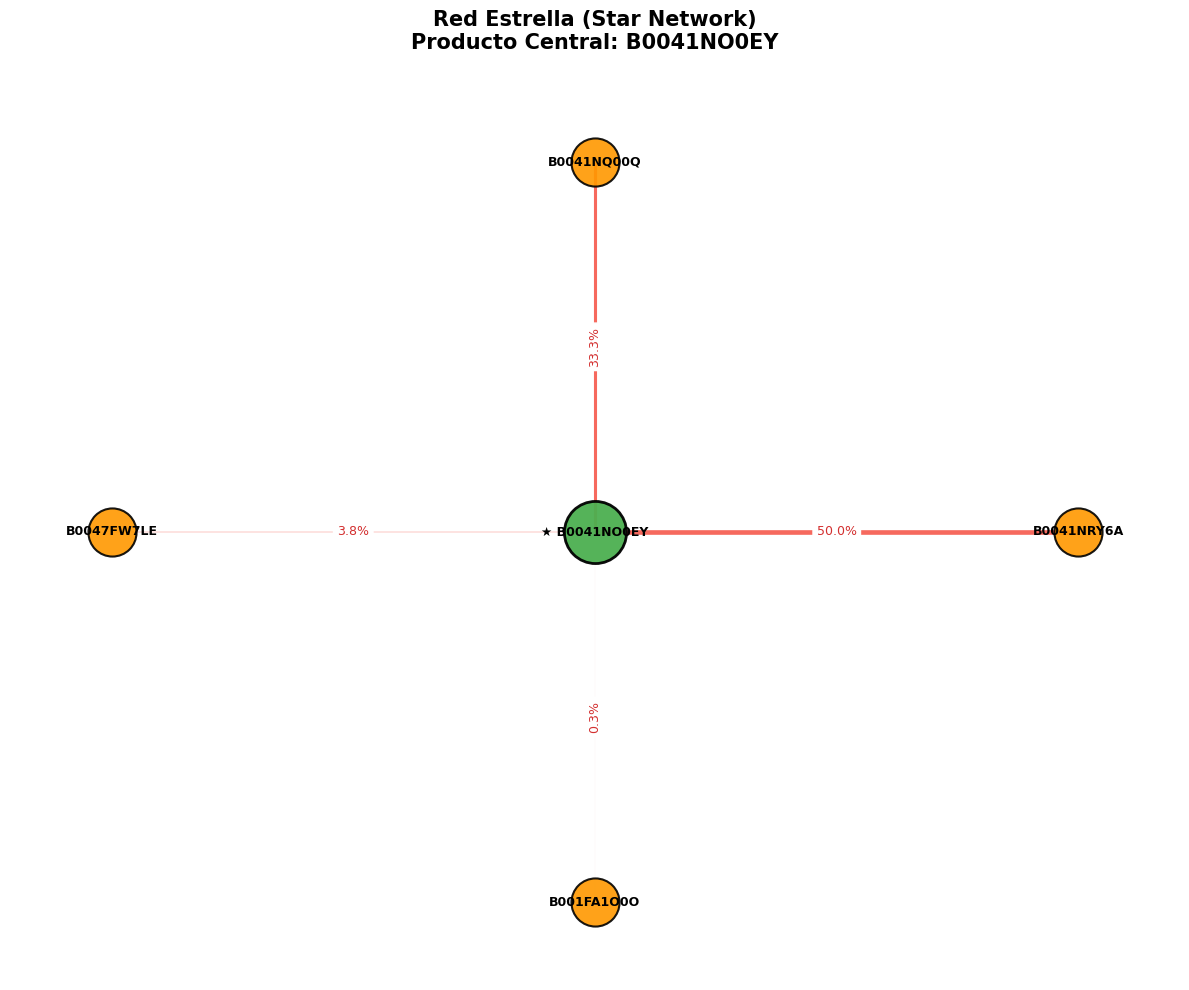


PRODUCTO CENTRAL: B0041NO0EY

Rank   Producto ID                                        Similaridad 
--------------------------------------------------------------------------------
1      B0041NRY6A                                          50.00%
2      B0041NQ00Q                                          33.33%
3      B0047FW7LE                                           3.85%
4      B001FA1O0O                                           0.30%



In [44]:
def visualize_star_network(product_id, n_recommendations=4):
    """Visualiza red estrella: producto central con vecinos conectados por aristas rojas"""
    recs = get_product_recommendations(product_id, n_recommendations, exclude_perfect_match=False)
    
    if not recs:
        print(f"No hay recomendaciones para {product_id}")
        return
    
    # Crear grafo estrella
    G = nx.Graph()
    G.add_node(product_id)
    
    for neighbor, sim, _ in recs:
        G.add_node(neighbor)
        G.add_edge(product_id, neighbor, weight=sim)
    
    # Posiciones: centro y vecinos en círculo
    pos = {product_id: (0, 0)}
    angle_step = 2 * np.pi / len(recs)
    for i, (neighbor, _, _) in enumerate(recs):
        pos[neighbor] = (np.cos(i * angle_step), np.sin(i * angle_step))
    
    # Visualización
    plt.figure(figsize=(12, 10))
    
    # Nodo central (producto seleccionado)
    nx.draw_networkx_nodes(G, pos, nodelist=[product_id], 
                          node_color='#4CAF50', 
                          node_size=2000, 
                          alpha=0.95,
                          edgecolors='black',
                          linewidths=2)
    
    # Nodos vecinos (productos recomendados)
    nx.draw_networkx_nodes(G, pos, nodelist=[n for n, _, _ in recs], 
                          node_color='#FF9800', 
                          node_size=1200, 
                          alpha=0.9,
                          edgecolors='black',
                          linewidths=1.5)
    
    # Aristas rojas con grosor variable según similaridad
    edge_widths = [sim/15 for _, sim, _ in recs]
    nx.draw_networkx_edges(G, pos, 
                          edge_color='#F44336', 
                          width=edge_widths, 
                          alpha=0.8)
    
    # Etiquetas de nodos (IDs truncados)
    labels = {product_id: f"★ {product_id[-10:]}"}
    labels.update({n: n[-10:] for n, _, _ in recs})
    nx.draw_networkx_labels(G, pos, labels, font_size=9, font_weight='bold')
    
    # Etiquetas de peso en las aristas
    edge_labels = {(product_id, n): f"{s:.1f}%" for n, s, _ in recs}
    nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=9, font_color='#D32F2F')
    
    plt.title(f'Red Estrella (Star Network)\nProducto Central: {product_id[-20:]}', 
             fontsize=15, fontweight='bold', pad=25)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Tabla de recomendaciones
    print(f"\n{'='*80}")
    print(f"PRODUCTO CENTRAL: {product_id}")
    print(f"{'='*80}")
    print(f"\n{'Rank':<6} {'Producto ID':<50} {'Similaridad':<12}")
    print(f"{'-'*80}")
    for i, (prod, sim, _) in enumerate(recs, 1):
        print(f"{i:<6} {prod:<50} {sim:>6.2f}%")
    print(f"{'='*80}\n")

# Demostración con un producto válido
valid_prods = [p for p in products if p in product_network and len(product_network[p]) >= 4]
if valid_prods:
    visualize_star_network(valid_prods[0], n_recommendations=5)

### Interfaz Interactiva con Dropdowns

Selección de producto y número de recomendaciones mediante widgets interactivos.

In [41]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Productos válidos (con suficientes vecinos)
valid_products = [p for p in products if p in product_network and len(product_network[p]) >= 4][:50]

# Crear dropdowns
product_dropdown = widgets.Dropdown(
    options=valid_products,
    description='Producto:',
    style={'description_width': 'initial'}
)

n_dropdown = widgets.Dropdown(
    options=[3, 4, 5, 6, 8, 10],
    value=4,
    description='N Recomendaciones:',
    style={'description_width': 'initial'}
)

# Función de actualización
def update_visualization(change):
    with output:
        clear_output(wait=True)
        visualize_star_network(product_dropdown.value, n_dropdown.value)

# Vincular eventos
product_dropdown.observe(update_visualization, names='value')
n_dropdown.observe(update_visualization, names='value')

# Output widget
output = widgets.Output()

# Mostrar interfaz
display(widgets.VBox([product_dropdown, n_dropdown, output]))

# Visualización inicial
with output:
    visualize_star_network(product_dropdown.value, n_dropdown.value)

---

## 📈 Resumen del Sistema

### Características Principales

✅ **Grafo Bipartito**: Conecta usuarios y productos mediante calificaciones de 5 estrellas  
✅ **Proyección Ponderada**: Red de productos donde los pesos representan usuarios compartidos  
✅ **Similaridad de Jaccard**: Métrica normalizada que mide similitud entre productos (0-100%)  
✅ **Filtrado Inteligente**: Elimina productos con pocas conexiones y opcionalmente duplicados perfectos  
✅ **Visualización Interactiva**: Red estrella con dropdowns para explorar recomendaciones  
✅ **Matriz de Biadyacencia**: Representación visual del grafo bipartito  

### Métricas y Resultados

- **Dataset**: Amazon Electronics Reviews
- **Filtrado**: Solo reseñas de 5 estrellas
- **Umbral**: Mínimo 4 conexiones por usuario/producto
- **Algoritmo**: Similaridad de Jaccard basada en usuarios compartidos
- **Rango típico**: 0.3% - 50% de similaridad (valores realistas)
- **Casos especiales**: 100% indica productos idénticos (duplicados/variantes)

### Uso del Sistema

1. Ejecutar celdas en orden secuencial
2. Usar los dropdowns interactivos para seleccionar productos
3. Ajustar el número de recomendaciones deseadas
4. Visualizar la red estrella y métricas de similaridad